In [1]:
import sys, os
print("Kernel Python:", sys.executable)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn import metrics

import torch
print("PyTorch:", torch.__version__)

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import pytorch_lightning as pl
from tqdm import tqdm

from tqdm import tqdm
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print("Current location:", os.getcwd())

# from esm.models.esmc import ESMC
# from esm.sdk.api import ESMProtein, LogitsConfig

Kernel Python: /work3/s232958/envs/esm_cuda/bin/python3.10
PyTorch: 2.9.1+cu128


/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'Could not load this library: /work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/torchvision/image.so'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


Using device: cuda
Current location: /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts


In [2]:
def gaussian_kernel(x, sigma):
    return np.exp(-x**2 / (2 * sigma**2))

def transform_vector(vector, sigma):

    interacting_indices = np.where(vector == 1)[0]   # positions where vector == 1
    transformed_vector = np.zeros_like(vector, dtype=float)
    
    for i in range(len(vector)):
        if vector[i] == 0:
            distances = np.abs(interacting_indices - i)   # distance to all "1"s
            min_distance = np.min(distances)              # closest "1"
            transformed_vector[i] = gaussian_kernel(min_distance, sigma)
        else:
            transformed_vector[i] = 1.0
    return transformed_vector

def safe_shuffle(n, device):
    shuffled = torch.randperm(n, device=device)
    while torch.any(shuffled == torch.arange(n, device=device)):
        shuffled = torch.randperm(n, device=device)
    return shuffled

def create_key_padding_mask(embeddings, padding_value=0, offset=10):
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1152] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

class MiniCLIP_w_transformer_crossattn(pl.LightningModule):

    def __init__(self, padding_value = -5000, embed_dimension=1152, num_recycles=2):

        super().__init__()
        self.num_recycles = num_recycles # how many times you iteratively refine embeddings with self- and cross-attention (ALPHA-Fold-style recycling).
        self.padding_value = padding_value
        self.embed_dimension = embed_dimension

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))  # ~CLIP init

        self.transformerencoder =  nn.TransformerEncoderLayer(
            d_model=self.embed_dimension,
            nhead=8,
            dropout=0.1,
            batch_first=True,
            dim_feedforward=self.embed_dimension
            )
 
        self.norm = nn.LayerNorm(self.embed_dimension)  # For residual additions

        self.cross_attn = nn.MultiheadAttention(
            embed_dim=self.embed_dimension,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        self.prot_embedder = nn.Sequential(
            nn.Linear(self.embed_dimension, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )
        
    def forward(self, pep_input, prot_input, pep_int_mask=None, prot_int_mask=None, int_prob=None, mem_save=True): # , pep_tokens, prot_tokens

        pep_mask = create_key_padding_mask(embeddings=pep_input,padding_value=self.padding_value)
        prot_mask = create_key_padding_mask(embeddings=prot_input,padding_value=self.padding_value)
 
        # Initialize residual states
        # pep_emb = pep_input.clone()
        # prot_emb = prot_input.clone()

        pep_emb  = pep_input
        prot_emb = prot_input
 
        for _ in range(self.num_recycles):

            # Transformer encoding with residual
            pep_trans = self.transformerencoder(self.norm(pep_emb), src_key_padding_mask=pep_mask)
            prot_trans = self.transformerencoder(self.norm(prot_emb), src_key_padding_mask=prot_mask)

            # Cross-attention with residual
            pep_cross, _ = self.cross_attn(query=self.norm(pep_trans), key=self.norm(prot_trans), value=self.norm(prot_trans), key_padding_mask=prot_mask)
            prot_cross, _ = self.cross_attn(query=self.norm(prot_trans), key=self.norm(pep_trans), value=self.norm(pep_trans), key_padding_mask=pep_mask)
            
            # Additive update with residual connection
            pep_emb = pep_emb + pep_cross  
            prot_emb = prot_emb + prot_cross

        pep_seq_coding = create_mean_of_non_masked(pep_emb, pep_mask)
        prot_seq_coding = create_mean_of_non_masked(prot_emb, prot_mask)
        
        # Use self-attention outputs for embeddings
        pep_seq_coding = F.normalize(self.prot_embedder(pep_seq_coding))
        prot_seq_coding = F.normalize(self.prot_embedder(prot_seq_coding))
 
        if mem_save:
            torch.cuda.empty_cache()
        
        scale = torch.exp(self.logit_scale).clamp(max=100.0)
        logits = scale * (pep_seq_coding * prot_seq_coding).sum(dim=-1) # Dot-Product for comparison
        
        return logits
    

    def training_step(self, batch, device):
        # Passing the sequences to the models
 
        embedding_pep = batch[0]
        embedding_prot = batch[1]
 
        embedding_pep = embedding_pep.to(device)
        embedding_prot = embedding_prot.to(device)

        positive_logits = self(embedding_pep, embedding_prot)
        
        rows, cols = torch.triu_indices(embedding_prot.size(0), embedding_prot.size(0), offset=1)         
        
        negative_logits = self(embedding_pep[rows,:,:], embedding_prot[cols,:,:], int_prob=0.0)

        positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device))
 
        # loss of predicting peptide using partner
        negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))
        
        loss = (positive_loss + negative_loss) / 2
 
        torch.cuda.empty_cache()
        return loss
    
    def validation_step(self, batch, device):
        # Predict on random batches of training batch size
        embedding_pep = batch[0]
        embedding_prot = batch[1]
        embedding_pep = embedding_pep.to(device)
        embedding_prot = embedding_prot.to(device)

        with torch.no_grad():

            positive_logits = self(
                    embedding_pep,
                    embedding_prot,
                    # interaction_pep,
                    # interaction_prot,
                    # int_prob = 0.0
                    )
            
            # loss of predicting partner using peptide
            positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device))
            
            # Negaive indexes
            rows, cols = torch.triu_indices(embedding_prot.size(0), embedding_prot.size(0), offset=1) 
            

            negative_logits = self(embedding_pep[rows,:,:], 
                              embedding_prot[cols,:,:], 
                              int_prob=0.0)
                   
            
            negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))

            loss = (positive_loss + negative_loss) / 2
           
            logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
            logit_matrix[rows, cols] = negative_logits
            logit_matrix[cols, rows] = negative_logits
            
            # Fill diagonal with positive scores
            diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
            logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()

            labels = torch.arange(embedding_prot.size(0)).to(self.device)
            peptide_predictions = logit_matrix.argmax(dim=0)
            peptide_ranks = logit_matrix.argsort(dim=0).diag() + 1
            peptide_mrr = (peptide_ranks).float().pow(-1).mean()
            
            # partner_accuracy = partner_predictions.eq(labels).float().mean()
            peptide_accuracy = peptide_predictions.eq(labels).float().mean()
    
            k = 3
            peptide_topk_accuracy = torch.any((logit_matrix.topk(k, dim=0).indices - labels.reshape(1, -1)) == 0, dim=0).sum() / logit_matrix.shape[0]
            # partner_topk_accuracy = torch.any((logits.topk(k, dim=1).indices - labels.reshape(-1, 1)) == 0, dim=1).sum() / logits.shape[0]
    
            del logit_matrix,positive_logits,negative_logits,embedding_pep,embedding_prot

            return loss, peptide_accuracy, peptide_topk_accuracy

    def calculate_logit_matrix(self,embedding_pep,embedding_prot):
        positive_logits = self(
            embedding_pep,
            embedding_prot)
        
        # Negaive indexes
        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1) 
        
        negative_logits = self(embedding_pep[rows,:,:], 
                      embedding_prot[cols,:,:], 
                      int_prob=0.0)
        
        logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
        logit_matrix[rows, cols] = negative_logits
        logit_matrix[cols, rows] = negative_logits
        # Fill diagonal with positive scores
        diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
        logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()
        return logit_matrix

In [3]:
### original
path = '../PPI_PLM/models/CLIP_no_structural_information/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_4/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_epoch_4.pth'
checkpoint = torch.load(path, weights_only=False, map_location=torch.device('cpu'))
# print(list(checkpoint["model_state_dict"]))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MiniCLIP_w_transformer_crossattn()
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()  # or model.train()

MiniCLIP_w_transformer_crossattn(
  (transformerencoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
    )
    (linear1): Linear(in_features=1152, out_features=1152, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1152, out_features=1152, bias=True)
    (norm1): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (norm): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
  (cross_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
  )
  (prot_embedder): Sequential(
    (0): Linear(in_features=1152, out_features=640, bias=True)
    (1): ReLU()
    (2): Linear(in_features=640, out_features=32

### PPint-test

In [4]:
Df_test = pd.read_csv("/work3/s232958/data/PPint_DB/PPint_test.csv",index_col=0).reset_index(drop=True)

class CLIP_PPint_dataclass(Dataset):
    def __init__(
        self,
        dframe,
        path,
        embedding_dim=1280,
        embedding_pad_value=-5000.0,
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim = int(embedding_dim)
        self.emb_pad = float(embedding_pad_value)

        # lengths
        self.max_blen = self.dframe["seq_binder_len"].max()+2
        self.max_tlen = self.dframe["seq_target_len"].max()+2

        # paths
        self.encoding_path  = path

        # index & storage
        self.dframe.set_index("target_binder_id", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings and contacts"):
            parts = accession.split("_") # e.g. accession 7S8T_5_F_7S8T_5_G
            tgt_id = parts[0]+"_"+parts[2]
            bnd_id = parts[-3]+"_"+parts[-1]

            ### --- embeddings (pad to fixed lengths) --- ###
            
            # laod embeddings
            t_emb = np.load(os.path.join(self.encoding_path, f"{tgt_id}.npy")).squeeze(0)     # [Lt, D]
            b_emb = np.load(os.path.join(self.encoding_path, f"{bnd_id}.npy")).squeeze(0)     # [Lb, D]

            # print(b_emb.shape[0], self.dframe.loc[accession].seq_binder_len)
            assert (b_emb.shape[0] == self.dframe.loc[accession].seq_binder_len+2)
            assert (t_emb.shape[0] == self.dframe.loc[accession].seq_target_len+2)

            # quich check whether embedding dimmension is as it suppose to be
            if t_emb.shape[1] != self.embedding_dim or b_emb.shape[1] != self.embedding_dim:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")

            # add -5000 to all the padded target rows
            if t_emb.shape[0] < self.max_tlen:
                t_emb = np.concatenate([t_emb, np.full((self.max_tlen - t_emb.shape[0], t_emb.shape[1]), self.emb_pad, dtype=t_emb.dtype)], axis=0)
            else:
                t_emb = t_emb[: self.max_tlen] # no padding was used

            # add -5000 to all the padded binder rows
            if b_emb.shape[0] < self.max_blen:
                b_emb = np.concatenate([b_emb, np.full((self.max_blen - b_emb.shape[0], b_emb.shape[1]), self.emb_pad, dtype=b_emb.dtype)], axis=0)
            else:
                b_emb = b_emb[: self.max_blen] # no padding was used

            self.samples.append((b_emb, t_emb))

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        b_arr, t_arr = self.samples[idx]
        binder_emb, target_emb = torch.from_numpy(b_arr).float(), torch.from_numpy(t_arr).float()
        label = torch.tensor(1, dtype=torch.float32)  # single scalar labe
        return binder_emb, target_emb, label

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        b_list, t_list, lbl_list = zip(*out)
    
        # Stack embeddings
        b  = torch.stack([torch.as_tensor(x) for x in b_list],  dim=0)  # [B, ...]
        t  = torch.stack([torch.as_tensor(x) for x in t_list],  dim=0)  # [B, ...]
    
        # Stack labels
        labels = torch.stack(lbl_list)  # [B]
    
        return b, t, labels

emb_path = "/work3/s232958/data/PPint_DB/embeddings_esmC"

testing_Dataset = CLIP_PPint_dataclass(
    Df_test,
    path=emb_path,
    embedding_dim=1152
)

Df_test_non_dimer = Df_test[Df_test.dimer == False]

non_dimers_Dataset = CLIP_PPint_dataclass(
    Df_test_non_dimer,
    path=emb_path,
    embedding_dim=1152
)

#Loading ESM2 embeddings and contacts: 100%|███████████████████████████████████████████| 747/747 [00:05<00:00, 139.94it/s]


### meta-analysis

In [5]:
all_meta_dataframe = pd.read_csv("/work3/s232958/data/meta_analysis/source_data.csv")
all_meta_dataframe = all_meta_dataframe[(all_meta_dataframe["A_seq"].notna())& (all_meta_dataframe["B_seq"].notna())].reset_index(drop=True)
all_meta_dataframe = all_meta_dataframe[all_meta_dataframe["target_chains"] == "[\"B\"]"]
all_meta_dataframe = all_meta_dataframe[all_meta_dataframe["B_seq"].notna()].reset_index(drop=True)
columns = ["binder_id", "colab_iptm_model_0", "boltz1_iptm_model_0", "boltz1_complex_plddt_model_0", "af3_iptm_model_0"]

interaction_df = pd.read_csv("/work3/s232958/data/meta_analysis/interaction_df_metaanal.csv")

interaction_Df02 = interaction_df.merge(all_meta_dataframe[columns], on="binder_id")
interaction_Df02 = interaction_Df02.drop(columns = ["binder_id", "target_id"]).rename(columns = {
    "A_seq" : "seq_binder",
    "B_seq" : "seq_target",
    "target_binder_ID" : "binder_id",
    "target_id_mod" : "target_id",
    "binder" : "binder_label"
})
interaction_Df02["seq_binder_len"] = [len(row.seq_binder) for __, row in interaction_Df02.iterrows()]
interaction_Df02["seq_target_len"] = [len(row.seq_target) for __, row in interaction_Df02.iterrows()]

interaction_Df02

class CLIP_Meta_class(Dataset):
    def __init__(
        self,
        dframe,
        paths,
        embedding_dim=1152,
        embedding_pad_value=-5000.0
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim = int(embedding_dim)
        self.emb_pad = float(embedding_pad_value)
        self.max_blen = self.dframe["seq_binder_len"].max()+2
        self.max_tlen = self.dframe["seq_target_len"].max()+2

        # paths
        self.encoding_bpath, self.encoding_tpath = paths

        # index & storage
        self.dframe.set_index("binder_id", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings"):
            lbl = torch.tensor(int(self.dframe.loc[accession, "binder_label"]))
            parts = accession.split("_") # e.g. accession 7S8T_5_F_7S8T_5_G
            tgt_id = "_".join(parts[:-1])
            bnd_id = accession

            ### --- embeddings (pad to fixed lengths) --- ###
            
            # laod embeddings
            t_emb = np.load(os.path.join(self.encoding_tpath, f"{tgt_id}.npy")).squeeze(0)     # [Lt, D]
            b_emb = np.load(os.path.join(self.encoding_bpath, f"{bnd_id}.npy")).squeeze(0)      # [Lb, D]

            # print(b_emb.shape[0], self.dframe.loc[accession].seq_binder_len)
            assert (b_emb.shape[0] == self.dframe.loc[accession].seq_binder_len+2)
            assert (t_emb.shape[0] == self.dframe.loc[accession].seq_target_len+2)

            # quich check whether embedding dimmension is as it suppose to be
            if t_emb.shape[1] != self.embedding_dim or b_emb.shape[1] != self.embedding_dim:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")

            # add -5000 to all the padded target rows
            if t_emb.shape[0] < self.max_tlen:
                t_emb = np.concatenate([t_emb, np.full((self.max_tlen - t_emb.shape[0], t_emb.shape[1]), self.emb_pad, dtype=t_emb.dtype)], axis=0)
            else:
                t_emb = t_emb[: self.max_tlen] # no padding was used

            # add -5000 to all the padded binder rows
            if b_emb.shape[0] < self.max_blen:
                b_emb = np.concatenate([b_emb, np.full((self.max_blen - b_emb.shape[0], b_emb.shape[1]), self.emb_pad, dtype=b_emb.dtype)], axis=0)
            else:
                b_emb = b_emb[: self.max_blen] # no padding was used

            self.samples.append((b_emb, t_emb, lbl))

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        b_arr, t_arr, lbls = self.samples[idx]
        binder_emb, target_emb = torch.from_numpy(b_arr).float(), torch.from_numpy(t_arr).float()
        return binder_emb, target_emb, lbls

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        b_list, t_list, lbl_list = zip(*out)
    
        # Stack embeddings
        b  = torch.stack([torch.as_tensor(x) for x in b_list],  dim=0)  # [B, ...]
        t  = torch.stack([torch.as_tensor(x) for x in t_list],  dim=0)  # [B, ...]
    
        # Stack labels
        labels = torch.stack(lbl_list)  # [B]
    
        return b, t, labels

bemb_path = "/work3/s232958/data/meta_analysis/embeddings_esmC_binders"
temb_path = "/work3/s232958/data/meta_analysis/embeddings_esmC_targets"

validation_Dataset = CLIP_Meta_class(
    # interaction_df_shuffled[:len(Df_test)],
    interaction_Df02,
    paths=[bemb_path, temb_path],
    embedding_dim=1152
)

#Loading ESM2 embeddings: 100%|██████████████████████████████████████████████████████| 3532/3532 [00:22<00:00, 155.14it/s]


### BindCraft

In [6]:
bindcraft_Df = pd.read_csv("/work3/s232958/data/bindcraft/bindcraft_with_target_seq.csv")
bindcraft_Df = bindcraft_Df[bindcraft_Df.target_id != "CbAgo"]
bindcraft_Df = bindcraft_Df[~bindcraft_Df.binder_label.isna()]

class CLIP_bindcraft_dataset(Dataset):
    def __init__(
        self,
        dframe,
        path,
        embedding_dim=1152,
        embedding_pad_value=-5000.0,
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim = int(embedding_dim)
        self.emb_pad = float(embedding_pad_value)
        self.encoding_path = path

        # lengths
        self.max_blen = self.dframe["len_seq_binder"].max()
        self.max_tlen = self.dframe["len_seq_target"].max()

        # index & storage
        self.dframe.set_index("binder_id", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESMC embeddings"):
            tgt_id = self.dframe.loc[accession]["target_id"]
            bnd_id = accession
            lbl = torch.tensor(int(self.dframe.loc[accession, "binder_label"]))

            ### --- embeddings (pad to fixed lengths) --- ###
            
            # laod embeddings
            t_emb = np.load(os.path.join(self.encoding_path, f"{tgt_id}.npy"))[0]     # [Lt, D]
            b_emb = np.load(os.path.join(self.encoding_path, f"{bnd_id}.npy"))[0]     # [Lb, D]

            # quich check whether embedding dimmension is as it suppose to be
            if t_emb.shape[1] != self.embedding_dim or b_emb.shape[1] != self.embedding_dim:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")

            # add -5000 to all the padded target rows
            if t_emb.shape[0] < self.max_tlen:
                t_emb = np.concatenate([t_emb, np.full((self.max_tlen - t_emb.shape[0], t_emb.shape[1]), self.emb_pad, dtype=t_emb.dtype)], axis=0)
            else:
                t_emb = t_emb[: self.max_tlen] # no padding was used

            # add -5000 to all the padded binder rows
            if b_emb.shape[0] < self.max_blen:
                b_emb = np.concatenate([b_emb, np.full((self.max_blen - b_emb.shape[0], b_emb.shape[1]), self.emb_pad, dtype=b_emb.dtype)], axis=0)
            else:
                b_emb = b_emb[: self.max_blen] # no padding was used

            self.samples.append((b_emb, t_emb, lbl))

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        b_emb, t_emb, lbl = self.samples[idx]
        b_emb, t_emb = torch.from_numpy(b_emb).float(), torch.from_numpy(t_emb).float()
        return b_emb, t_emb, lbl

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        b_list, t_list, lbl_list = zip(*out)
    
        # Stack embeddings
        b  = torch.stack([torch.as_tensor(x) for x in b_list],  dim=0)  # [B, ...]
        t  = torch.stack([torch.as_tensor(x) for x in t_list],  dim=0)  # [B, ...]
        lbl  = torch.stack([torch.as_tensor(x) for x in lbl_list],  dim=0)  # [B, ...]
    
        return b, t, lbl

bindcraft_dataset = CLIP_bindcraft_dataset(bindcraft_Df, path = "/work3/s232958/data/bindcraft/embeddings_esmC", embedding_dim=1152)

#Loading ESMC embeddings: 100%|████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 167.03it/s]


### BoltzGen

In [7]:
boltzgen_Df = pd.read_csv("/work3/s232958/data/boltzgen/boltzgen_df_filtered.csv")

class CLIP_boltzgen_dataset(Dataset):
    def __init__(
        self,
        dframe,
        path,
        embedding_dim=1152,
        embedding_pad_value=-5000.0,
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim = int(embedding_dim)
        self.emb_pad = float(embedding_pad_value)
        self.encoding_path = path

        # lengths
        self.max_blen = self.dframe["len_binder_seq"].max()
        self.max_tlen = self.dframe["len_target_seq"].max()

        # index & storage
        self.dframe.set_index("binder_id2", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESMC embeddings"):
            tgt_id = self.dframe.loc[accession]["target_id"]
            bnd_id = accession
            lbl = torch.tensor(int(self.dframe.loc[accession, "binder"]))

            ### --- embeddings (pad to fixed lengths) --- ###
            
            # laod embeddings
            t_emb = np.load(os.path.join(self.encoding_path, f"{tgt_id}.npy"))[0]     # [Lt, D]
            b_emb = np.load(os.path.join(self.encoding_path, f"{bnd_id}.npy"))[0]     # [Lb, D]

            # quich check whether embedding dimmension is as it suppose to be
            if t_emb.shape[1] != self.embedding_dim or b_emb.shape[1] != self.embedding_dim:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")

            # add -5000 to all the padded target rows
            if t_emb.shape[0] < self.max_tlen:
                t_emb = np.concatenate([t_emb, np.full((self.max_tlen - t_emb.shape[0], t_emb.shape[1]), self.emb_pad, dtype=t_emb.dtype)], axis=0)
            else:
                t_emb = t_emb[: self.max_tlen] # no padding was used

            # add -5000 to all the padded binder rows
            if b_emb.shape[0] < self.max_blen:
                b_emb = np.concatenate([b_emb, np.full((self.max_blen - b_emb.shape[0], b_emb.shape[1]), self.emb_pad, dtype=b_emb.dtype)], axis=0)
            else:
                b_emb = b_emb[: self.max_blen] # no padding was used

            self.samples.append((b_emb, t_emb, lbl))

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        b_emb, t_emb, lbl = self.samples[idx]
        b_emb, t_emb = torch.from_numpy(b_emb).float(), torch.from_numpy(t_emb).float()
        return b_emb, t_emb, lbl

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        b_list, t_list, lbl_list = zip(*out)
    
        # Stack embeddings
        b  = torch.stack([torch.as_tensor(x) for x in b_list],  dim=0)  # [B, ...]
        t  = torch.stack([torch.as_tensor(x) for x in t_list],  dim=0)  # [B, ...]
        lbl  = torch.stack([torch.as_tensor(x) for x in lbl_list],  dim=0)  # [B, ...]
    
        return b, t, lbl
        
boltzgen_dataset = CLIP_boltzgen_dataset(boltzgen_Df, path = "/work3/s232958/data/boltzgen/embeddings_esmC", embedding_dim=1152)

#Loading ESMC embeddings: 100%|████████████████████████████████████████████████████████| 422/422 [00:02<00:00, 150.18it/s]


### Evaluating

In [6]:
def collate_varlen(batch):
    b_emb = torch.stack([x[0] for x in batch], dim=0)
    t_emb = torch.stack([x[1] for x in batch], dim=0)
    lbls = torch.tensor([x[2].float() for x in batch])
    return b_emb, t_emb, lbls

test_dataloader = DataLoader(testing_Dataset, batch_size=10, collate_fn=collate_varlen)
non_dimers_dataloader = DataLoader(non_dimers_Dataset, batch_size=10, collate_fn=collate_varlen)
meta_dataloader = DataLoader(validation_Dataset, batch_size=10, shuffle=False, drop_last = False, collate_fn=collate_varlen)
boltzgen_dataloader = DataLoader(boltzgen_dataset, batch_size=10, shuffle=False, drop_last = False, collate_fn=collate_varlen)
bindcraft_dataloader = DataLoader(bindcraft_dataset, batch_size=10, shuffle=False, drop_last = False, collate_fn=collate_varlen)

#### PPint-test

#Iterating through batched data: 100%|██████████████████████████████████████████████████| 198/198 [01:09<00:00,  2.83it/s]


Positives: (1978,)
Negatives: (8893,)


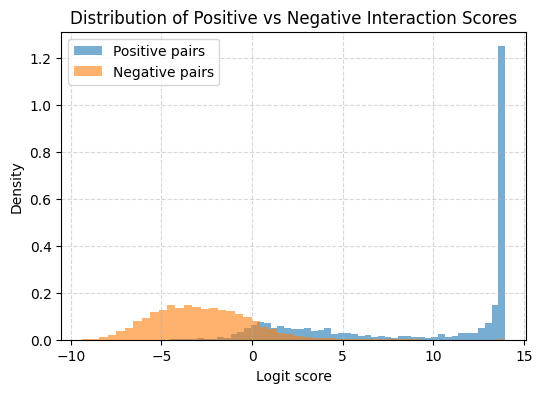

In [40]:
interaction_scores_pos = []
interaction_scores_neg = []
all_scores = []
all_lbls = []

for batch in tqdm(test_dataloader, total=round(len(Df_test)/10), desc="#Iterating through batched data"):
    b_emb, t_emb, lbls = batch
    embedding_pep = b_emb.to("cuda")
    embedding_prot = t_emb.to("cuda")

    with torch.no_grad():

        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1)
        positive_logits = model(embedding_pep, embedding_prot)
        negative_logits = model(embedding_pep[rows,:,:], embedding_prot[cols,:,:], int_prob=0.0)
        
        logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device="cuda")
        logit_matrix[rows, cols] = negative_logits
        logit_matrix[cols, rows] = negative_logits
        
        diag_indices = torch.arange(embedding_pep.size(0), device="cuda")
        logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()
        
        # print(logit_matrix)
        interaction_scores_pos.append(positive_logits)
        interaction_scores_neg.append(negative_logits)
        all_scores.append(positive_logits)
        all_lbls.append(np.ones(len(positive_logits)))
        all_scores.append(negative_logits)
        all_lbls.append(np.zeros(len(negative_logits)))

# Convert list of tensors to single 1D tensors
pos_logits = torch.cat(interaction_scores_pos).detach().cpu().numpy().flatten()
neg_logits = torch.cat(interaction_scores_neg).detach().cpu().numpy().flatten()

# Since all_lbls contains numpy arrays, use np.concatenate instead of torch.cat
all_scores_np = np.concatenate([s.detach().cpu().numpy().flatten() for s in all_scores])
all_lbls_np = np.concatenate(all_lbls)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_lbls_np, all_scores_np)
roc_auc = auc(fpr, tpr)

# Plotting with your specific colors
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='#dd8452', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='#4c72b0', lw=2, linestyle='--') # Baseline

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
sns.despine()
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

#### PPint-non-dimer

In [7]:
all_scores = []
all_labels = []

model.eval()

for batch in tqdm(non_dimers_dataloader, total=len(non_dimers_dataloader), desc="# Iterating through batched data"):
    b_emb, t_emb, lbls = batch
    
    # Move embeddings to GPU
    embedding_pep = b_emb.to("cuda")
    embedding_prot = t_emb.to("cuda")

    with torch.no_grad():
        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1) 
        positive_logits = model(embedding_pep, embedding_prot)
        negative_logits = model(embedding_pep[rows,:,:], embedding_prot[cols,:,:], int_prob=0.0)

        all_scores.append(positive_logits.detach().cpu())
        all_scores.append(negative_logits.detach().cpu())
        all_labels.append(torch.ones(positive_logits.size(0)))
        all_labels.append(torch.zeros(negative_logits.size(0)))

y_scores = torch.cat(all_scores).numpy()
y_true = torch.cat(all_labels).numpy()

pos_logits = y_scores[y_true == 1]
neg_logits = y_scores[y_true == 0]

print(f"Total Positive Samples: {len(pos_logits)}")
print(f"Total Negative Samples: {len(neg_logits)}")
print(f"Average Positive Logit: {np.mean(pos_logits):.2f}")
print(f"Average Negative Logit: {np.mean(neg_logits):.2f}")

# Iterating through batched data: 100%|███████████████████████████████████████████████████| 75/75 [00:27<00:00,  2.72it/s]

Total Positive Samples: 747
Total Negative Samples: 3351
Average Positive Logit: 2.76
Average Negative Logit: -2.95


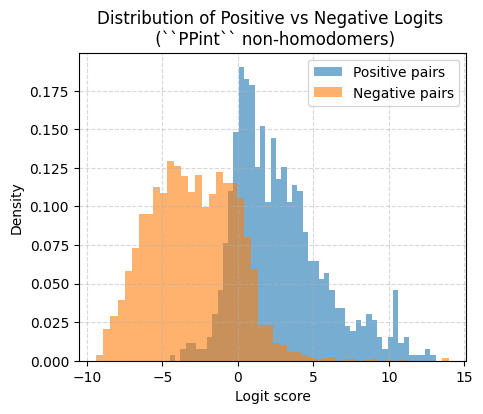

In [10]:
# Convert list of tensors to single 1D tensors
print(f'Average score for postive logits is: {pos_logits.mean()} and for negative logits is: {neg_logits.mean()}')

PPint_pos_logits = torch.cat(interaction_scores_pos).detach().cpu().numpy()
PPint_neg_logits = torch.cat(interaction_scores_neg).detach().cpu().numpy()
print("Positives:", pos_logits.shape)
print("Negatives:", neg_logits.shape)

plt.figure(figsize=(6, 4))
plt.hist(PPint_pos_logits, bins=50, alpha=0.6, label="Positive pairs", density=True)
plt.hist(PPint_neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)
plt.axvline(PPint_pos_logits.mean(), linestyle="--", linewidth=2,label=f"Positive mean = {pos_logits.mean():.2f}", color="red")
plt.axvline(PPint_neg_logits.mean(), linestyle="--", linewidth=2,label=f"Negative mean = {neg_logits.mean():.2f}")
plt.grid(True, linestyle="--", alpha=0.5)
plt.xlabel("Logit score")
plt.ylabel("Density")
plt.title('Distribution of Positive vs Negative Logits \n "PPint" non-homodomers', fontsize=12)
plt.legend()
plt.show()

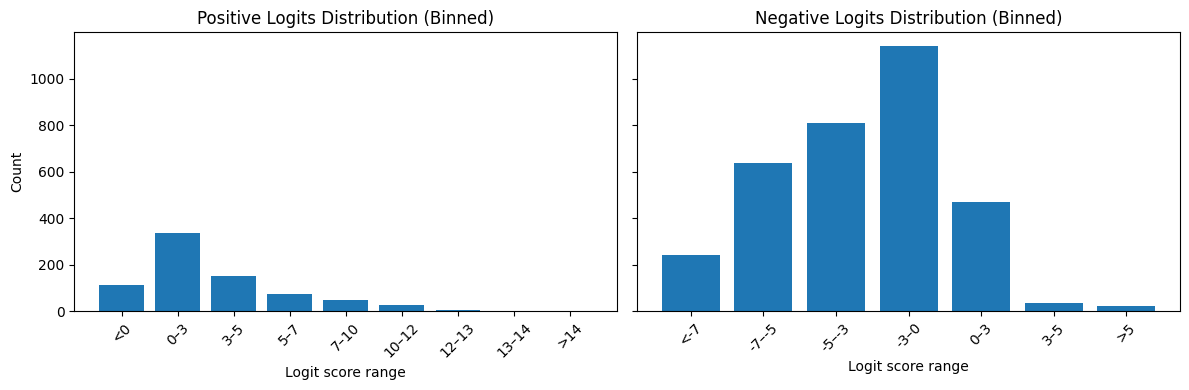

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# --- Positive logits ---
bins_pos = [-np.inf, 0, 3, 5, 7, 10, 12, 13, 14, np.inf]
labels_pos = ["<0", "0–3", "3–5", "5–7", "7–10", "10–12", "12–13", "13–14", ">14"]

counts_pos, _ = np.histogram(pos_logits, bins=bins_pos)

axes[0].bar(labels_pos, counts_pos)
axes[0].set_xlabel("Logit score range")
axes[0].set_ylabel("Count")
axes[0].set_title("Positive Logits Distribution (Binned)")
axes[0].tick_params(axis="x", rotation=45)

# --- Negative logits ---
bins_neg = [-np.inf, -7, -5, -3, 0, 3, 5, np.inf]
labels_neg = ["<-7", "-7–-5", "-5–-3", "-3–0", "0–3", "3–5", ">5"]

counts_neg, _ = np.histogram(neg_logits, bins=bins_neg)

axes[1].bar(labels_neg, counts_neg)
axes[1].set_xlabel("Logit score range")
axes[1].set_title("Negative Logits Distribution (Binned)")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [12]:
len(y_true)

4098

AUPR: 0.730


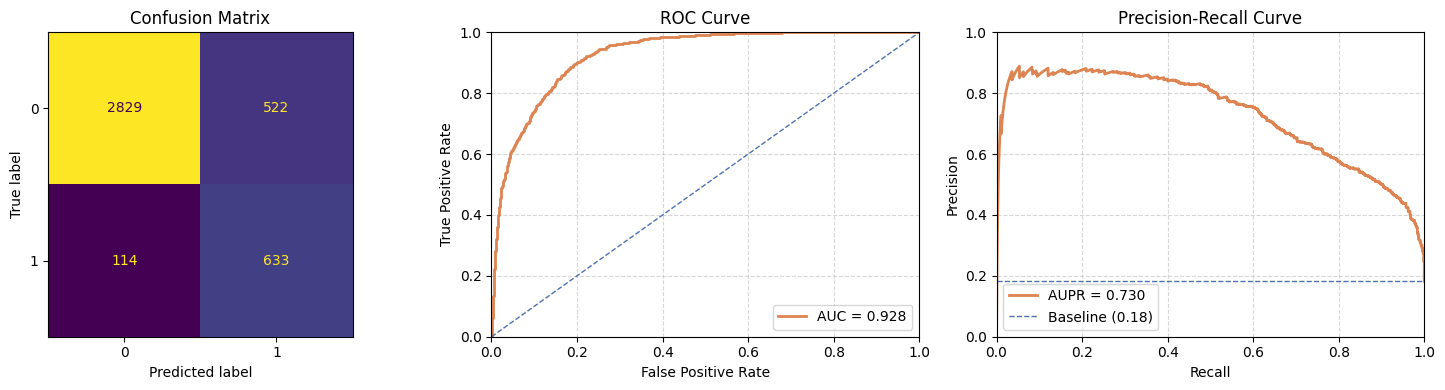

In [14]:
color_true = "#dd8452" # Orange
color_false = "#4c72b0" # Blue

y_true = []
for lbl_array in all_labels:
    for lbl in lbl_array:
        y_true.append(lbl)

y_score = torch.cat(all_scores).detach().cpu().numpy()

y_prob  = 1 / (1 + np.exp(-y_score))                  # sigmoid
pred_labels = (y_prob >= 0.5).astype(int)

# choose which to use for ROC: logits or probs (both are fine)
scores_for_roc = y_score   # or y_prob

# 1. Calculate AUPR metrics
precision, recall, _ = metrics.precision_recall_curve(y_true, y_score)
aupr_score = metrics.average_precision_score(y_true, y_score)
print(f"AUPR: {aupr_score:.3f}")

# 2. Setup 1x3 Grid
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# --- Plot 1: Confusion Matrix ---
cm = metrics.confusion_matrix(y_true, pred_labels)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=axes[0], values_format="d", colorbar=False) 
axes[0].set_title("Confusion Matrix")
axes[0].grid(False)

# --- Plot 2: ROC Curve ---
PPint_fpr, PPint_tpr, _ = metrics.roc_curve(y_true, scores_for_roc)
PPint_auc = metrics.roc_auc_score(y_true, scores_for_roc)

axes[1].plot(PPint_fpr, PPint_tpr, color=color_true, linewidth=2, label=f"AUC = {PPint_auc:.3f}")
axes[1].plot([0, 1], [0, 1], color=color_false, linestyle="--", linewidth=1)
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title('ROC Curve')
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)
axes[1].legend(loc="lower right")
axes[1].grid(True, linestyle="--", alpha=0.5)

# --- Plot 3: AUPR Curve ---
axes[2].plot(recall, precision, color=color_true, linewidth=2, label=f"AUPR = {aupr_score:.3f}")
# Baseline for PR is the ratio of positives
baseline = sum(y_true) / len(y_true)
axes[2].axhline(y=baseline, color=color_false, linestyle="--", linewidth=1, label=f"Baseline ({baseline:.2f})")
axes[2].set_xlim(0, 1)
axes[2].set_ylim(0, 1)
axes[2].set_xlabel("Recall")
axes[2].set_ylabel("Precision")
axes[2].set_title("Precision-Recall Curve")
axes[2].legend(loc="lower left")
axes[2].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

#### meta-analysis

In [15]:
# Loading batches
interaction_scores = []

for batch in tqdm(meta_dataloader, total = round(len(interaction_Df02)/10),  desc= "#Iterating through batched data"):
    b_emb, t_emb, lbls = batch
    embedding_pep = b_emb.to("cuda")
    embedding_prot = t_emb.to("cuda")

    with torch.no_grad():
        positive_logits = model(embedding_pep, embedding_prot)
        interaction_scores.append(positive_logits.unsqueeze(0))

predicted_interaction_scores = np.concatenate([batch_score.cpu().detach().numpy().reshape(-1,) for batch_score in interaction_scores])
interaction_probabilities = np.concatenate([torch.sigmoid(batch_score[0]).cpu().numpy() for batch_score in interaction_scores])

meta_pos_logits, meta_neg_logits = [], []
for i, row in interaction_Df02.iterrows():
    logit = predicted_interaction_scores[i]
    if row.binder_label == False:
        meta_neg_logits.append(logit)
    elif row.binder_label == True:
        meta_pos_logits.append(logit)

NameError: name 'meta_dataloader' is not defined

In [16]:
print(f'Average score for postive logits is: {np.mean(meta_pos_logits)} and for negative logits is: {np.mean(meta_neg_logits)}')
plt.figure(figsize=(6, 4))
plt.hist(meta_pos_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)
plt.hist(meta_neg_logits, bins=50, alpha=0.6, label="Positive pairs", density=True)
plt.axvline(np.mean(meta_pos_logits), linestyle="--", linewidth=2,label=f"Positive mean = {np.mean(meta_pos_logits):.2f}", color="red")
plt.axvline(np.mean(meta_neg_logits), linestyle="--", linewidth=2,label=f"Negative mean = {np.mean(meta_neg_logits):.2f}")
plt.xlabel("Logit score")
plt.ylabel("Density")
plt.title('Distribution of Positive vs Negative Logits \n "meta-analysis" dataset')

# --- Simple grid behind ---
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'meta_pos_logits' is not defined

In [16]:
predicted_interaction_scores = np.concatenate([batch_score.cpu().detach().numpy().reshape(-1,) for batch_score in interaction_scores])
interaction_probabilities = np.concatenate([torch.sigmoid(batch_score[0]).cpu().numpy() for batch_score in interaction_scores])

interaction_Df02["inter_prob"] = interaction_probabilities
interaction_Df02["pred_binder"] = interaction_Df02["inter_prob"] >= 0.5
interaction_Df02["intr_scores"] = predicted_interaction_scores

interaction_Df02

,binder_chain,target_chains,binder_label,seq_binder,seq_target,target_id,binder_id,colab_iptm_model_0,boltz1_iptm_model_0,boltz1_complex_plddt_model_0,af3_iptm_model_0,seq_binder_len,seq_target_len,inter_prob,pred_binder,intr_scores
0,A,"[""B""]",False,LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...,VirB8,VirB8_1,0.38,0.893,0.948,0.59,40,138,0.191018,False,-1.443412
1,A,"[""B""]",False,SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1,0.24,0.260,0.756,0.37,62,101,0.572728,True,0.292991
2,A,"[""B""]",False,DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2,0.25,0.457,0.764,0.39,61,101,0.662400,True,0.674007
3,A,"[""B""]",False,DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_3,0.88,0.177,0.810,0.51,64,101,0.819741,True,1.514594
4,A,"[""B""]",False,PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_4,0.26,0.290,0.768,0.30,64,101,0.676389,True,0.737228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3527,A,"[""B""]",False,DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_62,0.90,0.908,0.825,0.73,55,165,0.877317,True,1.967262
3528,A,"[""B""]",False,SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_63,0.87,0.928,0.825,0.81,56,165,0.920716,True,2.452114
3529,A,"[""B""]",False,SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_64,0.87,0.917,0.813,0.76,56,165,0.556427,True,0.226673
3530,A,"[""B""]",False,DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_65,0.91,0.559,0.802,0.55,57,165,0.583039,True,0.335260


In [17]:
labels = torch.as_tensor(interaction_Df02["binder_label"].to_numpy(copy=False), dtype=torch.float32, device=device)
logits = torch.as_tensor(predicted_interaction_scores, dtype=torch.float32, device=device)

loss = F.binary_cross_entropy_with_logits(logits, labels)
loss

pred_labels = interaction_probabilities >= 0.5
true_labels = np.array(interaction_Df02["binder_label"])

true_positives = ((pred_labels == 1) & (true_labels == 1)).sum().item()
true_negatives = ((pred_labels == 0) & (true_labels == 0)).sum().item()
false_positives = ((pred_labels == 1) & (true_labels == 0)).sum().item()
false_negatives = ((pred_labels == 0) & (true_labels == 1)).sum().item()

predicted_positives = true_positives + false_positives
all_real_positives = true_positives + false_negatives

print(metrics.classification_report(true_labels, pred_labels, digits = 4))

              precision    recall  f1-score   support

       False     0.9284    0.2932    0.4457      3141
        True     0.1260    0.8184    0.2184       391

    accuracy                         0.3514      3532
   macro avg     0.5272    0.5558    0.3320      3532
weighted avg     0.8396    0.3514    0.4205      3532



AUC: 0.585


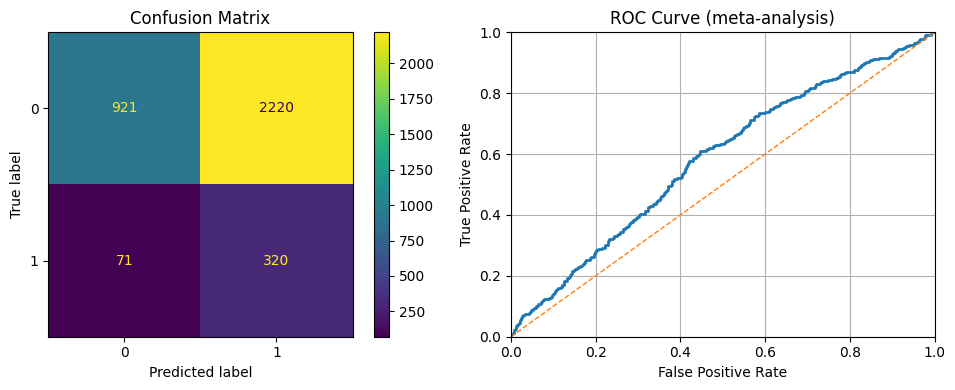

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

disp = metrics.ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(true_labels, pred_labels))
disp.plot(ax=axes[0])
axes[0].set_title("Confusion Matrix")

TPR = true_positives / (true_positives + true_negatives) # how good the model is at predicting the positive class when the actual outcome is positive.
# sensitivity = true_positives / (true_positives + false_negatives) # the same as TPR
FPR = false_positives / (false_positives + true_negatives) # how often a positive class is predicted when the actual outcome is negative.
# specificity = true_negatives / (true_negatives + false_positives) # FPR = 1 - specificity

meta_fpr, meta_tpr, thresholds = metrics.roc_curve(true_labels, predicted_interaction_scores)
meta_auc = metrics.roc_auc_score(true_labels, predicted_interaction_scores)
print('AUC: %.3f' % meta_auc)

axes[1].plot(meta_fpr, meta_tpr, linewidth=2)
axes[1].plot([0, 1], [0, 1], linestyle="--", linewidth=1)  # diagonal reference
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)
axes[1].set_title('ROC Curve (meta-analysis)')
axes[1].grid(True)

# show the plot
plt.tight_layout()
plt.show()

#### bindacraft

In [19]:
# Loading batches
interaction_scores, all_scores = [], []
all_label_temp, all_labels = [], []

for batch in tqdm(bindcraft_dataloader, total = round(len(bindcraft_Df)/10),  desc= "#Iterating through batched data"):
    b_emb, t_emb, lbls = batch
    embedding_pep = b_emb.to("cuda")
    embedding_prot = t_emb.to("cuda")

    with torch.no_grad():
        positive_logits = model(embedding_pep, embedding_prot)
        interaction_scores.append(positive_logits.unsqueeze(0))
        all_label_temp.append(lbls)

predicted_interaction_scores = np.concatenate([batch_score.cpu().detach().numpy().reshape(-1,) for batch_score in interaction_scores])
interaction_probabilities = np.concatenate([torch.sigmoid(batch_score[0]).cpu().numpy() for batch_score in interaction_scores])

for lbl_array in all_label_temp:
    for lbl in lbl_array:
        all_labels.append(lbl.detach().cpu().float().item())

#Iterating through batched data: 100%|████████████████████████████████████████████████████| 15/15 [00:00<00:00, 16.36it/s]


Average score for postive logits is: 0.7723062634468079 and for negative logits is: 0.4191635251045227


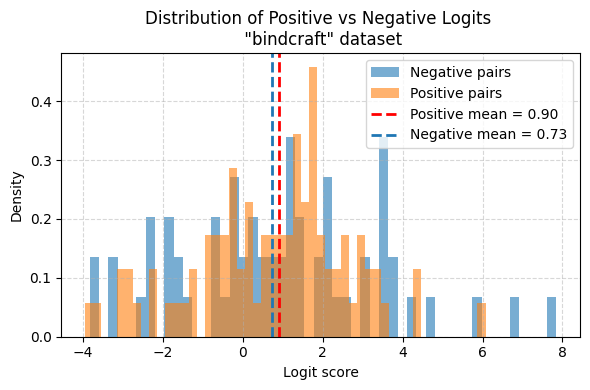

In [20]:
bc_pos_logits, bc_neg_logits= [], []

for i, score in enumerate(predicted_interaction_scores):
    if all_labels[i] == 1:
        bc_pos_logits.append(predicted_interaction_scores[i])
    elif all_labels[i] == 0:
        bc_neg_logits.append(predicted_interaction_scores[i])

print(f'Average score for postive logits is: {np.mean(meta_pos_logits)} and for negative logits is: {np.mean(meta_neg_logits)}')
plt.figure(figsize=(6, 4))
plt.hist(bc_pos_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)
plt.hist(bc_neg_logits, bins=50, alpha=0.6, label="Positive pairs", density=True)
plt.axvline(np.mean(bc_pos_logits), linestyle="--", linewidth=2,label=f"Positive mean = {np.mean(bc_pos_logits):.2f}", color="red")
plt.axvline(np.mean(bc_neg_logits), linestyle="--", linewidth=2,label=f"Negative mean = {np.mean(bc_neg_logits):.2f}")
plt.xlabel("Logit score")
plt.ylabel("Density")
plt.title('Distribution of Positive vs Negative Logits \n "bindcraft" dataset')

# --- Simple grid behind ---
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

         0.0     0.5577    0.3333    0.4173        87
         1.0     0.4082    0.6349    0.4969        63

    accuracy                         0.4600       150
   macro avg     0.4829    0.4841    0.4571       150
weighted avg     0.4949    0.4600    0.4507       150

AUC: 0.509


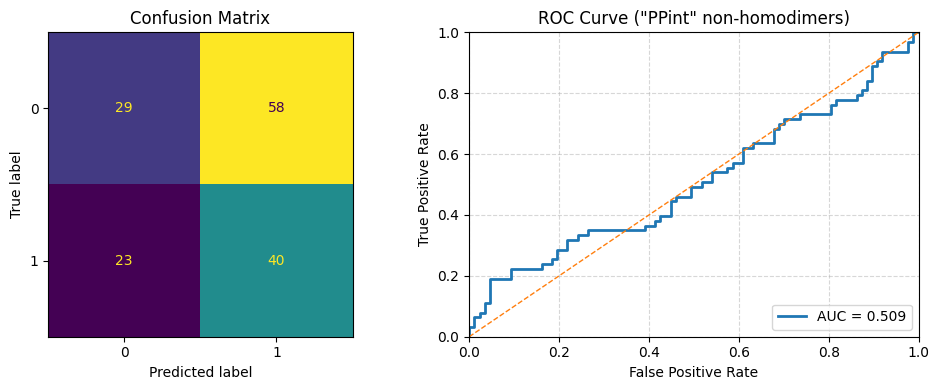

In [21]:
y_prob  = 1 / (1 + np.exp(-predicted_interaction_scores))                  # sigmoid
pred_labels = (y_prob >= 0.5).astype(int)

# choose which to use for ROC: logits or probs (both are fine)
scores_for_roc = predicted_interaction_scores   # or y_prob

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Confusion matrix
cm = metrics.confusion_matrix(all_labels, pred_labels)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=axes[0], values_format="d", colorbar=False)
axes[0].set_title("Confusion Matrix")
axes[0].grid(False)

print(metrics.classification_report(all_labels, pred_labels, digits=4))

# ROC
bc_fpr, bc_tpr, bc_thresholds = metrics.roc_curve(all_labels, scores_for_roc)
bc_auc = metrics.roc_auc_score(all_labels, scores_for_roc)
print(f"AUC: {bc_auc:.3f}")

axes[1].plot(bc_fpr, bc_tpr, linewidth=2, label=f"AUC = {bc_auc:.3f}")
axes[1].plot([0, 1], [0, 1], linestyle="--", linewidth=1)
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)
axes[1].set_title('ROC Curve ("PPint" non-homodimers)')
axes[1].legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

#### boltzgen

In [22]:
# Loading batches
interaction_scores, all_scores = [], []
all_label_temp, all_labels = [], []

for batch in tqdm(boltzgen_dataloader, total = round(len(boltzgen_Df)/10),  desc= "#Iterating through batched data"):
    b_emb, t_emb, lbls = batch
    embedding_pep = b_emb.to("cuda")
    embedding_prot = t_emb.to("cuda")

    with torch.no_grad():
        positive_logits = model(embedding_pep, embedding_prot)
        interaction_scores.append(positive_logits.unsqueeze(0))
        all_label_temp.append(lbls)

predicted_interaction_scores = np.concatenate([batch_score.cpu().detach().numpy().reshape(-1,) for batch_score in interaction_scores])
interaction_probabilities = np.concatenate([torch.sigmoid(batch_score[0]).cpu().numpy() for batch_score in interaction_scores])

for lbl_array in all_label_temp:
    for lbl in lbl_array:
        all_labels.append(lbl.detach().cpu().float().item())

#Iterating through batched data: 43it [00:04,  9.87it/s]                                                                  


Average score for postive logits is: 0.7723062634468079 and for negative logits is: 0.4191635251045227


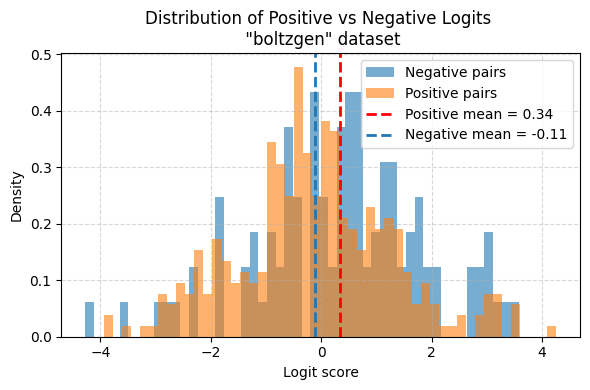

In [23]:
bz_pos_logits, bz_neg_logits= [], []

for i, score in enumerate(predicted_interaction_scores):
    if all_labels[i] == 1:
        bz_pos_logits.append(predicted_interaction_scores[i])
    elif all_labels[i] == 0:
        bz_neg_logits.append(predicted_interaction_scores[i])

print(f'Average score for postive logits is: {np.mean(meta_pos_logits)} and for negative logits is: {np.mean(meta_neg_logits)}')
plt.figure(figsize=(6, 4))
plt.hist(bz_pos_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)
plt.hist(bz_neg_logits, bins=50, alpha=0.6, label="Positive pairs", density=True)
plt.axvline(np.mean(bz_pos_logits), linestyle="--", linewidth=2,label=f"Positive mean = {np.mean(bz_pos_logits):.2f}", color="red")
plt.axvline(np.mean(bz_neg_logits), linestyle="--", linewidth=2,label=f"Negative mean = {np.mean(bz_neg_logits):.2f}")
plt.xlabel("Logit score")
plt.ylabel("Density")
plt.title('Distribution of Positive vs Negative Logits \n "boltzgen" dataset')

# --- Simple grid behind ---
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

         0.0     0.8084    0.5423    0.6492       319
         1.0     0.2981    0.6019    0.3987       103

    accuracy                         0.5569       422
   macro avg     0.5532    0.5721    0.5239       422
weighted avg     0.6839    0.5569    0.5880       422

AUC: 0.600


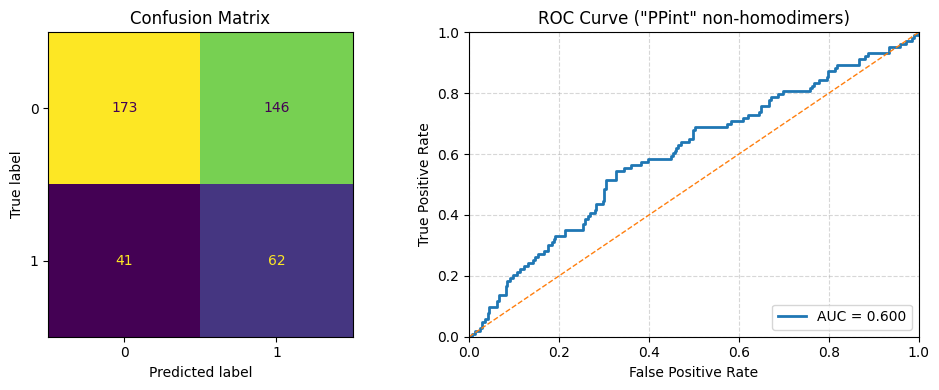

In [24]:
y_prob  = 1 / (1 + np.exp(-predicted_interaction_scores))                  # sigmoid
pred_labels = (y_prob >= 0.5).astype(int)

# choose which to use for ROC: logits or probs (both are fine)
scores_for_roc = predicted_interaction_scores   # or y_prob

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Confusion matrix
cm = metrics.confusion_matrix(all_labels, pred_labels)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=axes[0], values_format="d", colorbar=False)
axes[0].set_title("Confusion Matrix")
axes[0].grid(False)

print(metrics.classification_report(all_labels, pred_labels, digits=4))

# ROC
bz_fpr, bz_tpr, bz_thresholds = metrics.roc_curve(all_labels, scores_for_roc)
bz_auc = metrics.roc_auc_score(all_labels, scores_for_roc)
print(f"AUC: {bz_auc:.3f}")

axes[1].plot(bz_fpr, bz_tpr, linewidth=2, label=f"AUC = {bz_auc:.3f}")
axes[1].plot([0, 1], [0, 1], linestyle="--", linewidth=1)
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)
axes[1].set_title('ROC Curve ("PPint" non-homodimers)')
axes[1].legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

#### ALL

In [25]:
print(len(non_dimers_Dataset), len(interaction_Df02), len(boltzgen_Df), len(bindcraft_Df))

747 3532 422 150


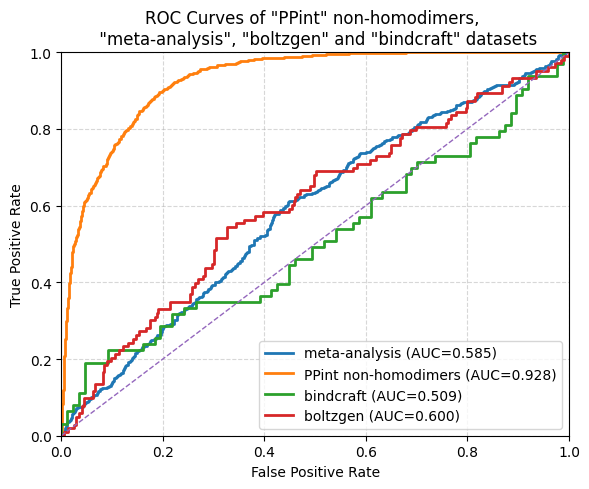

In [26]:
plt.figure(figsize=(6, 5))

plt.plot(meta_fpr, meta_tpr, linewidth=2, label=f"meta-analysis (AUC={meta_auc:.3f})")
plt.plot(PPint_fpr, PPint_tpr, linewidth=2, label=f"PPint non-homodimers (AUC={PPint_auc:.3f})")
plt.plot(bc_fpr, bc_tpr, linewidth=2, label=f"bindcraft (AUC={bc_auc:.3f})")
plt.plot(bz_fpr, bz_tpr, linewidth=2, label=f"boltzgen (AUC={bz_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('ROC Curves of "PPint" non-homodimers, \n "meta-analysis", "boltzgen" and "bindcraft" datasets')
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

In [ ]:
true_labels
pred_PPint = np.asarray(interaction_Df02.intr_scores)
pred_colab = np.asarray(interaction_Df02.colab_iptm_model_0)
pred_af3 = np.asarray(interaction_Df02.af3_iptm_model_0)
pred_boltz = np.asarray(interaction_Df02.boltz1_iptm_model_0)

AP_PPint = metrics.average_precision_score(true_labels, pred_PPint)
AP_colab = metrics.average_precision_score(true_labels, pred_colab)
AP_af3 = metrics.average_precision_score(true_labels, pred_af3)
AP_boltz = metrics.average_precision_score(true_labels, pred_boltz)

print(f"Average precission of PPint model:{AP_PPint:.4f}")
print(f"Average precission of colab model:{AP_colab:.4f}")
print(f"Average precission of AF3 model:{AP_af3:.4f}")
print(f"Average precission of Boltz model:{AP_boltz:.4f}")

### Boltz, Colab and AlphaFold predictions

#### AUC-ROC

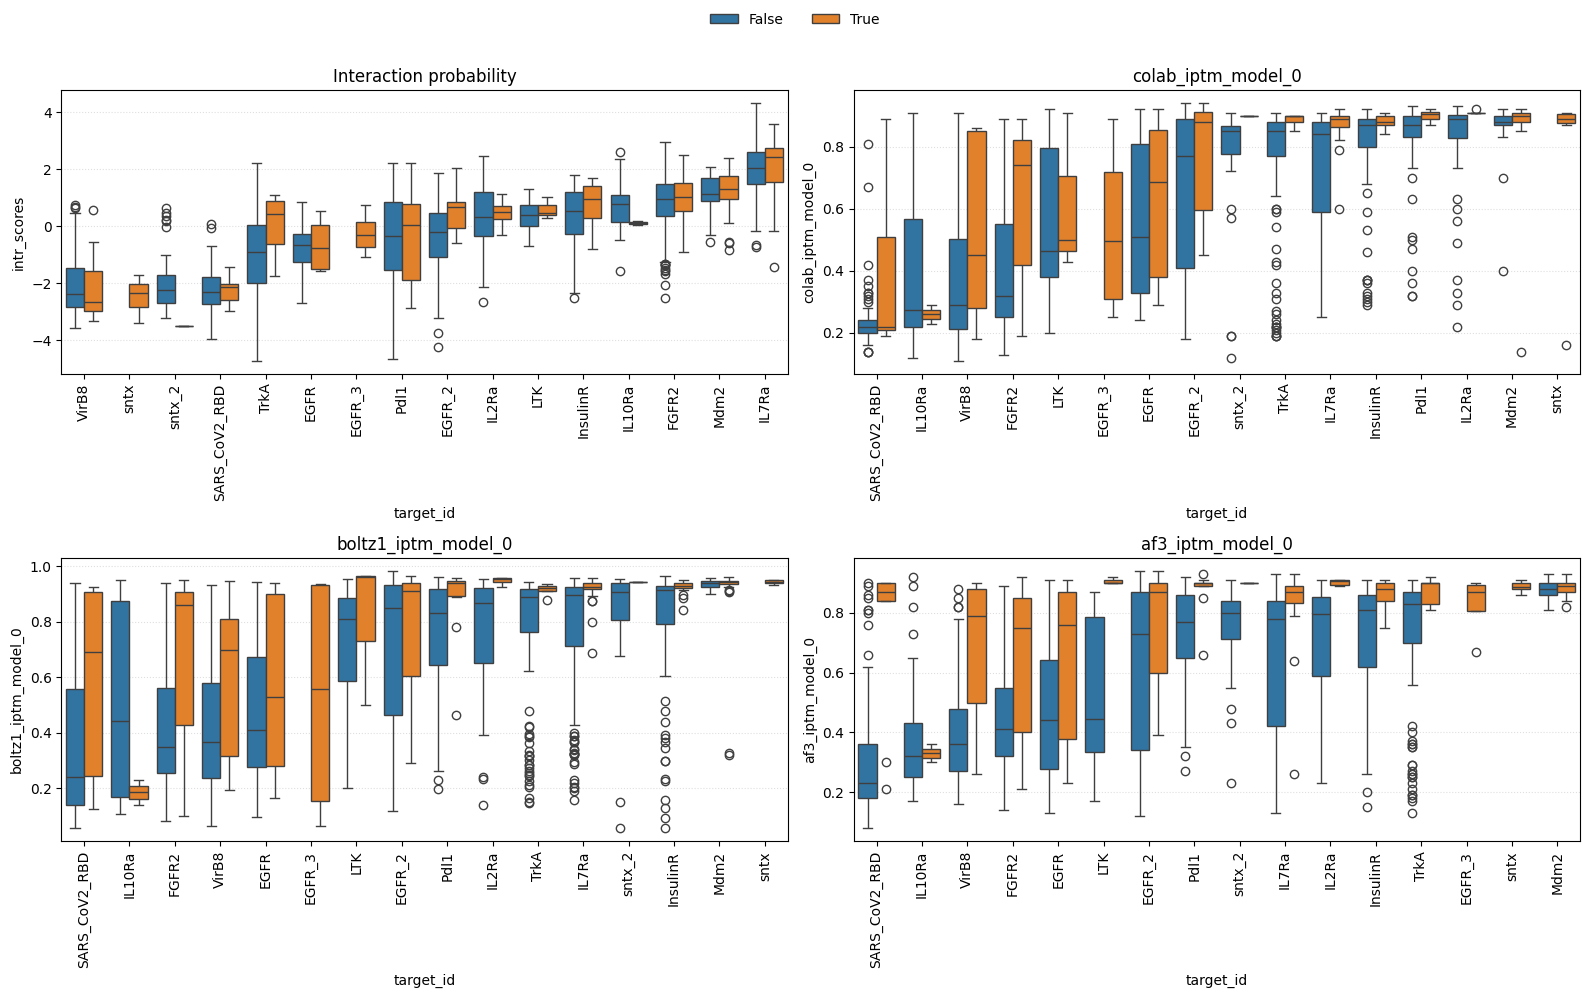

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
ax11, ax12 = axes[0]
ax21, ax22 = axes[1]

def plot_box(ax, ycol, title):
    # Optional: order targets by median value for nicer sorting
    order = (interaction_Df02.groupby("target_id")[ycol].median().sort_values().index)

    sns.boxplot(data=interaction_Df02, x="target_id", y=ycol, hue="binder_label", order=order, ax=ax)
    
    ax.set_title(title)
    ax.tick_params(axis="x", rotation=90)
    ax.grid(True, axis="y", linestyle=":", alpha=0.4)
    # Remove per-axes legend; we’ll add a single shared one
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()

plot_box(ax11, "intr_scores",           "Interaction probability")
plot_box(ax12, "colab_iptm_model_0",   "colab_iptm_model_0")
plot_box(ax21, "boltz1_iptm_model_0",  "boltz1_iptm_model_0")
plot_box(ax22, "af3_iptm_model_0",     "af3_iptm_model_0")

# Shared legend from the last plotted Axes
handles, labels = ax22.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=len(labels), frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for legend at top
plt.show()

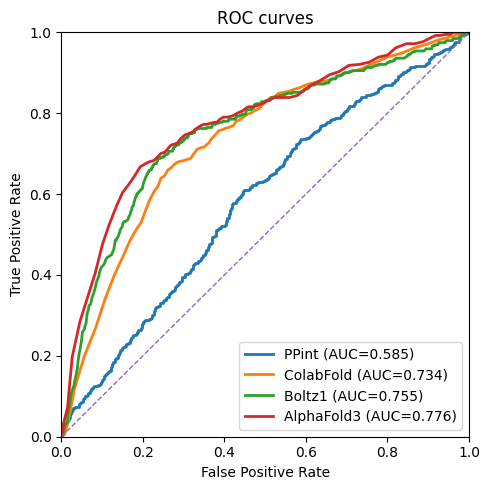

In [28]:
scores = {
    "PPint": np.asarray(interaction_Df02["intr_scores"]),
    "ColabFold": np.asarray(interaction_Df02["colab_iptm_model_0"]),
    "Boltz1": np.asarray(interaction_Df02["boltz1_iptm_model_0"]),
    "AlphaFold3": np.asarray(interaction_Df02["af3_iptm_model_0"]),
}

plt.figure(figsize=(5,5))
for model, values in scores.items():
    fpr, tpr, _ = metrics.roc_curve(true_labels, values)
    auc = metrics.roc_auc_score(true_labels, values)
    plt.plot(fpr, tpr, linewidth=2, label=f"{model} (AUC={auc:.3f})")

plt.plot([0,1],[0,1],"--", linewidth=1)
plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

#### AUC-PR

In [29]:
true_labels
pred_PPint = np.asarray(interaction_Df02.intr_scores)
pred_colab = np.asarray(interaction_Df02.colab_iptm_model_0)
pred_af3 = np.asarray(interaction_Df02.af3_iptm_model_0)
pred_boltz = np.asarray(interaction_Df02.boltz1_iptm_model_0)

AP_PPint = metrics.average_precision_score(true_labels, pred_PPint)
AP_colab = metrics.average_precision_score(true_labels, pred_colab)
AP_af3 = metrics.average_precision_score(true_labels, pred_af3)
AP_boltz = metrics.average_precision_score(true_labels, pred_boltz)

print(f"Average precission of PPint model:{AP_PPint:.4f}")
print(f"Average precission of colab model:{AP_colab:.4f}")
print(f"Average precission of AF3 model:{AP_af3:.4f}")
print(f"Average precission of Boltz model:{AP_boltz:.4f}")

Average precission of PPint model:0.1464
Average precission of colab model:0.2369
Average precission of AF3 model:0.3217
Average precission of Boltz model:0.2763


Average precision (AP):
  PPint: 0.1464
  ColabFold: 0.2369
  AlphaFold3: 0.3217
  Boltz1: 0.2763


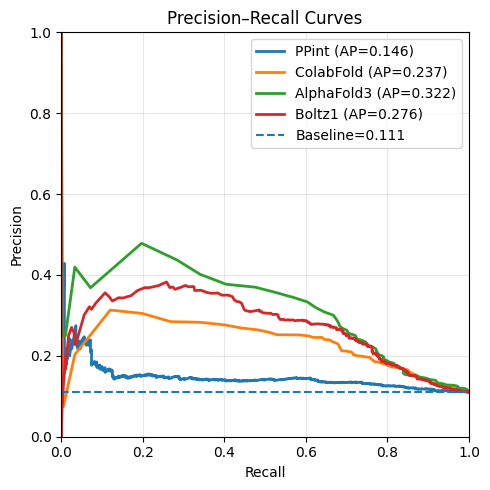

In [30]:
models = {
    "PPint": pred_PPint,
    "ColabFold": pred_colab,
    "AlphaFold3":   pred_af3,
    "Boltz1": pred_boltz,
}

# Compute and print APs
print("Average precision (AP):")
ap_values = {}
for name, scores in models.items():
    ap = metrics.average_precision_score(true_labels, scores)
    ap_values[name] = ap
    print(f"  {name}: {ap:.4f}")

# Plot PR curves
plt.figure(figsize=(5,5))

for name, scores in models.items():
    precision, recall, _ = metrics.precision_recall_curve(true_labels, scores)
    ap = ap_values[name]
    plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})", linewidth=2)

# Baseline = positive class prevalence
pos_rate = true_labels.mean()
plt.hlines(pos_rate, 0, 1, linestyles="dashed", label=f"Baseline={pos_rate:.3f}")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()